# Introduction
This notebook is intended to showcase a text classification proof-of-concept model, developed in TensorFlow.

The dataset used for this notebook is the [Stanford Large Movie Review (IMDB) dataset](http://ai.stanford.edu/~amaas/data/sentiment/).

# Data Exploration and Analysis
First, let's load our dataset into a `pandas` dataframe.

In [1]:
import pandas as pd
%matplotlib inline

In [14]:
reviews = pd.read_csv("data/reviews.txt", delimiter="\n", header=None, names=["review"])

In [16]:
labels = pd.read_csv("data/labels.txt", delimiter="\n", header=None, names=["label"])

Let's get an idea of what the dataset looks like here.

In [15]:
reviews.head()

,review
0,bromwell high is a cartoon comedy . it ran at ...
1,story of a man who has unnatural feelings for ...
2,homelessness or houselessness as george carli...
3,airport starts as a brand new luxury pla...
4,brilliant over acting by lesley ann warren . ...


In [17]:
labels.head()

,label
0,positive
1,negative
2,positive
3,negative
4,positive


Hmm, it looks like **review** can't fully fit in the above table.  
Let's grab the first review and see what it looks like:

In [19]:
reviews['review'][0]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   '

In [23]:
len(reviews['review'][0])

832

That's a good length movie review!  
Let's check how many reviews there are in the dataset:

In [20]:
len(reviews)

25000

The [Stanford Large Movie Review (IMDB) dataset](http://ai.stanford.edu/~amaas/data/sentiment/) is divided into positive and negative reviews.  
Let's check how many positive, and how many negative, reviews there are in this dataset:

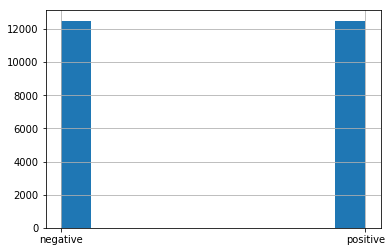

In [21]:
labels['label'].hist()

Excellent, the dataset is already balanced.  
Having a balanced dataset makes it easier to train a deep learning model, because it's less likely that the model will focus on one of the classes, and ignore the other.

Now, let's see what the distribution of review lengths is, in numbers of characters:

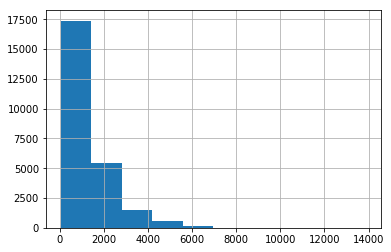

In [22]:
reviews['review'].apply(len).hist()

Ok, there are some much longer reviews in this dataset than the ~800 character review above, but most of them are under 2,500 characters.

# Data Preprocessing
The problem we are trying to solve here is called **sentiment analysis**, that is, whether the given text is positive or negative.

More broadly, this is a type of machine learning problem known as classification.

There are numerous different ways to think about the above dataset.  
We can think of it as a collection of characters, a sequence of characters, a collection of words, or a sequence of words.  
It turns out that the sequence-of-words approach has gotten good results on sentiment analysis problems, so let's think about the above dataset in those terms.

Let's consider another review in the dataset:

In [24]:
reviews['review'][5]

'this film lacked something i couldn  t put my finger on at first charisma on the part of the leading actress . this inevitably translated to lack of chemistry when she shared the screen with her leading man . even the romantic scenes came across as being merely the actors at play . it could very well have been the director who miscalculated what he needed from the actors . i just don  t know .  br    br   but could it have been the screenplay  just exactly who was the chef in love with  he seemed more enamored of his culinary skills and restaurant  and ultimately of himself and his youthful exploits  than of anybody or anything else . he never convinced me he was in love with the princess .  br    br   i was disappointed in this movie . but  don  t forget it was nominated for an oscar  so judge for yourself .  '

## Tokenization
What we would like to do is to turn the text above into a fixed-length sequence of numbers, which is what our TensorFlow model will expect in order to train on.

The basic idea behind working with text data is that we want to create a number for each unique "token" that we see, then we can just substitute a "token"'s number for the token itself, and arrive at a fixed-length sequence of numbers for TensorFlow to work with.

As can be seen above, it's not just words that are present, but also punctuation.  

Thankfully, the [natural language toolkit](http://www.nltk.org/) is excellent at turning a string of text into a list of tokens.

Let's see how it behaves on the above review:

In [25]:
import nltk

In [29]:
nltk.tokenize.word_tokenize(reviews['review'][5])[:25]

['this',
 'film',
 'lacked',
 'something',
 'i',
 'couldn',
 't',
 'put',
 'my',
 'finger',
 'on',
 'at',
 'first',
 'charisma',
 'on',
 'the',
 'part',
 'of',
 'the',
 'leading',
 'actress',
 '.',
 'this',
 'inevitably',
 'translated']

The above is perfectly sufficient tokenization for our purposes.  
Perhaps it could be improved upon slightly, but this breaks up our review into enough unique tokens that our model will be able to learn which ones to use and which ones to discount (more on that in the [Architecture](#Model-Architecture) section)

Now, let's create a set of all the words in all of the reviews in our dataset.  
We will use this set to create a lookup table of tokens to their "IDs".

In [30]:
review_word_set = set()
for r in reviews['review']:
    review_word_set.update(nltk.tokenize.word_tokenize(r))

In [31]:
len(review_word_set)

74069

Excellent, in our 25,000-review dataset, only some ~74,000 unique "tokens" have been used.  
## Token Encoding
Now, let's use this set to assign IDs to our tokens, so that we can easily go from a token to its ID, and vice versa.

First though, let's reserve ID `0` for reasons that will become clear in the [Padding](#Padding) section below, and start at ID `1`.

In [32]:
word_to_id = {word: i for i, word in enumerate(review_word_set, 1)}

In [33]:
word_to_id

{'joins': 1,
 'lutzky': 2,
 'completley': 3,
 'shamefull': 4,
 'yoo': 5,
 'ghettoisation': 6,
 'tailor': 7,
 'roderigo': 8,
 'jowls': 9,
 'constructed': 10,
 'roast': 11,
 'millenial': 12,
 'bleaked': 13,
 'encircle': 14,
 'astronomers': 15,
 'membership': 16,
 'soda': 17,
 'matinees': 18,
 'rallying': 19,
 'clapping': 20,
 'deliberate': 21,
 'endeavouring': 22,
 'bigscreen': 23,
 'takeaway': 24,
 'brutalizing': 25,
 'devon': 26,
 'unrequited': 27,
 'unkillable': 28,
 'bleibteu': 29,
 'prollific': 30,
 'thrifty': 31,
 'clairvoyant': 32,
 'avenging': 33,
 'tereza': 34,
 'psm': 35,
 'spellcasting': 36,
 'lem': 37,
 'alsobrook': 38,
 'monogamistic': 39,
 'vizier': 40,
 'kathleen': 41,
 'charlize': 42,
 'retailers': 43,
 'acception': 44,
 'interlinking': 45,
 'robes': 46,
 'terrifies': 47,
 'ambushing': 48,
 'squeeze': 49,
 'abhi': 50,
 'youve': 51,
 'rodeo': 52,
 'genre': 53,
 'lambada': 54,
 'volume': 55,
 'disloyalty': 56,
 'tapdancing': 57,
 'assedness': 58,
 'orthographic': 59,
 'dosa

Excellent, we're much closer to being able to having our dataset in a form that TensorFlow can work with.  
Just for sanity, let's see what the review above would look like as a list of the IDs above:

In [35]:
[word_to_id[word] for word in nltk.tokenize.word_tokenize(reviews['review'][5])][:10]

[64425, 45592, 14606, 17254, 3039, 12082, 33021, 24031, 44721, 12911]

I'm going to trust that the above is mostly correct, but let's at least check that `this` matches the first index in the above list:

In [36]:
word_to_id["this"]

64425

Perfect.  Now, let's convert all of the tokenized reviews into lists of `ID`s

In [37]:
reviews_as_ids = []
for review in reviews['review']:
    reviews_as_ids.append([word_to_id[word] for word in nltk.tokenize.word_tokenize(review)])

Again, as a sanity check, the 6th item (0-indexed!) in the `reviews_as_ids` list should be the same as the list that we see two cells above:

In [39]:
reviews_as_ids[5][:10]

[64425, 45592, 14606, 17254, 3039, 12082, 33021, 24031, 44721, 12911]

Excellent, we have now transformed our dataset of movie reviews into a list of integers.  

## Label Encoding
Now, let's generate an array that we can use with TensorFlow from the labels in the dataset.

In [40]:
import numpy as np

In [41]:
labels.head()

,label
0,positive
1,negative
2,positive
3,negative
4,positive


In [42]:
labels.tail()

,label
24995,negative
24996,positive
24997,negative
24998,positive
24999,negative


We have a list of the reviews which have been integer-tokenized, now let's generate a parallel numpy array of whether the review is positive or negative.

In [50]:
review_labels = np.array(labels['label'] == 'positive', dtype=int)

In [51]:
review_labels[:5]

array([1, 0, 1, 0, 1])

In [52]:
review_labels[-5:]

array([0, 1, 0, 1, 0])

As a sanity check, the length of this numpy array should be `25000`.

In [53]:
len(review_labels)

25000

## Padding
The reviews in our dataset contain a different length of tokens.

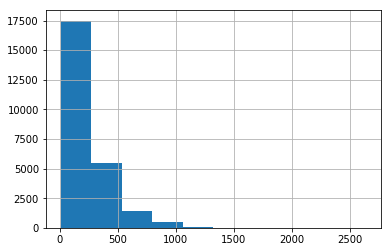

In [54]:
pd.Series(reviews_as_ids).apply(len).hist()

Most of our reviews are under ~500 tokens long, and a few are over 1,200 tokens.

The problem is that TensorFlow accepts only inputs of fixed length.  
Further, LSTMs often have a practical limitation of only working with sequences that are a few hundred items long.

This requires us to pick **a single token length** for our reviews as inputs.  
Reviews which are shorter than this will be padded on the **right** with `0`s, and reviews which are longer will have to be truncated before being fed to TensorFlow.

This is not as serious a limitation as it sounds, but it does have to be dealt with, or TensorFlow will throw errors during training.

Accordingly, let's define a **sequence length** that we will fit every review into.

In [55]:
seq_len = 200

x = np.zeros((len(reviews_as_ids), seq_len), dtype=int)
for i, review_as_id in enumerate(reviews_as_ids):
    x[i, :len(review_as_id)] = np.array(review_as_id)[:seq_len]

Shown below are two such sequences, one originally shorter than the sequence length, and one longer.

In [56]:
x[31], x[1506]

(array([23260, 59862, 48899, 48115, 65297, 23260, 26549, 22618, 54146,
        72749, 73035, 13906, 23260, 61768, 73323, 23260, 58446, 15032,
        72749, 17430, 59862, 48899, 48115, 65297, 52750, 39369, 40784,
        72749, 61680, 22618, 37809, 21420, 71831, 48899, 37466,  2428,
         2428, 14136, 29515, 52750, 65417, 15032, 54435, 54357, 61289,
        72749, 45592, 54357, 49116, 41960, 23097, 71700, 31926, 37466,
         7358, 32132,  9571, 32132, 25035, 54298, 14136, 49755, 18544,
        73323, 28098, 49755, 24050, 38966,  9026, 51345, 69655, 37466,
         2428,  2428, 72749, 52575, 52387, 32366, 71835, 38993, 42330,
        40784, 72749, 15374, 69841, 71835,  8807, 37466, 26180, 53389,
        65172, 70836, 58183, 17569, 65172, 42014, 72749, 65055, 37466,
        19706,  6709, 13214, 42345, 67180, 29696, 16190,  2299, 35255,
        24549,  2838, 25448, 23260, 69283, 18395, 51757,  2428,  2428,
        23260, 51554, 51545, 53111, 37466, 19706,  6709,  9559, 14155,
      

# Data Splitting and Shuffling

Now that we have transformed our dataset into a format that TensorFlow can work with, we need to split the dataset into training, testing, and validation sets, so that we can better evaluate the model's performance.

Let's use numpy to help us randomize here

In [57]:
## Use a seed for reproducibility of results
np.random.seed(42)
permute = np.random.permutation(range(len(x)))

In [58]:
## Generate shuffled versions of our data and labels
x_shuffled = x[permute]
y_shuffled = review_labels[permute]

In [59]:
## Use an 80% : 10% : 10% split into training : testing : validation sets
train_split = int(0.8*len(x))
test_split = int(0.9*len(x))

train_x = x_shuffled[:train_split]
test_x = x_shuffled[train_split:test_split]
val_x = x_shuffled[test_split:]

train_y = y_shuffled[:train_split]
test_y = y_shuffled[train_split:test_split]
val_y = y_shuffled[test_split:]

As a sanity check, let's look at the beginning of the split label sets, to confirm that the data has been shuffled.

In [63]:
train_y[:10]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0])

In [64]:
test_y[:10]

array([0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

In [65]:
val_y[:10]

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0])

As a final sanity check, note that an 80%, 10%, 10% split should yield numpy arrays of size `20000`, `2500`, and `2500`

In [66]:
len(train_x), len(test_x), len(val_x)

(20000, 2500, 2500)

# Checkpointing
We will use this opportunity to save our training, testing, and validation sets to disk, so that we can quickly load them in the future.

Should this notebook need to be run in the future, it can start from the [Loading](#Loading) cells below.
## Saving

In [67]:
import pickle

In [68]:
np.save("train_x", train_x)
np.save("train_y", train_y)
np.save("test_x", test_x)
np.save("test_y", test_y)
np.save("val_x", val_x)
np.save("val_y", val_y)
with open("review_word_set.pkl", 'wb') as f:
    pickle.dump(review_word_set, f)

## Loading

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_x = np.load("train_x.npy")
train_y = np.load("train_y.npy")
test_x = np.load("test_x.npy")
test_y = np.load("test_y.npy")
val_x = np.load("val_x.npy")
val_y = np.load("val_y.npy")
with open("review_word_set.pkl", 'rb') as f:
    review_word_set = pickle.load(f)

# Model Architecture
In this section, we will be defining a model architecture that we will use to "learn" the task of sentiment analysis.

As a broad overview, this will be a neural network that takes a sequence as input, and produces a value of either 0 (a negative review) or 1 (a positive review).

From the model's perspective, it will be seeing a vector of the above-defined **sequence length**, which is comprised of non-negative integers.

After the input, the first layer of the model will be "embedding" these non-negative integers into a smaller representational space of only a few hundred floating-point numbers, to allow it to learn which sequences are important, and which are mere noise.

Following this embedding layer, the "embedded" word vector will then pass into two parallel "stacks" of Long Short-Term Memory (LSTM) cells.

The advantage of an LSTM cell is that, throughout time, it is able to remember better what came several dozen items earlier in the sequence than is a typical "feed-forward" network.  A broad overview of the machinery that allows an LSTM cell to accomplish this memory throughout a time sequence is shown below.
![LSTM Cell, from colah's blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

Since our dataset is a sequence of words, it makes sense that the model would benefit from knowing about both the sequence going forward, and going backward.  Intuitively, the review "This movie has everything that you would expect.  And nothing you wouldn't," starts off very positive, and only at the end of the sequence would we start to think that the review is negative.  Knowing that from the beginning would make parsing the sequence easier.  
Language parsing is a [complicated task](https://research.googleblog.com/2016/05/announcing-syntaxnet-worlds-most.html) that is outside the scope of this notebook, but having this bi-directional parsing typically helps models to pick out what's important for sentiment classification.

The bi-directional stacked LSTM architecture that we implement below will be similar to (though not exactly the same as) the following architecture:
![bi-directional stacked LSTM, from WildML](http://www.wildml.com/wp-content/uploads/2015/09/Screen-Shot-2015-09-16-at-2.21.51-PM.png)

In the above architecture, each successive black dot may be thought of as a token in our reviews.  After embedding this token, we then pass it to a forward group of LSTM cells, and a backward stack of LSTM cells (both in orange), and then perhaps to more of the same "stacked" on top, which then generates outputs (red) at the top.

We then connect the red "output" cells to a single cell, since we want a single answer from the model, namely whether the given input review has a positive or a negative sentiment.

Thankfully, TensorFlow provides an API to implement the above, which we will explore below.

## Placeholders
Let's define the necessary placeholders in order for us to feed our pre-processed data from above into a TensorFlow model:

In [3]:
import tensorflow as tf

/home/human/miniconda3/envs/ProofOfConcept/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
graph = tf.Graph()

In [5]:
with graph.as_default():
    # Define placeholders to accept batches of token-sequences
    inputs = tf.placeholder(tf.int32, [None, None], name = "inputs")
    labels = tf.placeholder(tf.int32, [None, None], name = "labels")
    
    # Define a placeholder to allow us to tweak the dropout hyperparameter
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")

## Embedding
Many of the unique tokens that exist in our dataset, and thus have been assigned an `ID`, occur rarely.  
Things that occur rarely don't give a deep learning model much chance to learn what they mean, and so generally they hurt performance unless we take special steps to combat them.

As it turns out, we can probably condense the above ~47,000 unique tokens into a few hundred tokens, and still have the model perform well.  

This is done through the use of an ["embedding"](https://www.tensorflow.org/versions/master/tutorials/seq2seq#embedding) layer, which lets our model decide which of the tokens it sees are important, and which are just noise.

Thankfully, TensorFlow provides a compact way to define and use embeddings:

In [6]:
embedding_size = 300

with graph.as_default():
    # Define an embedding that allows us to map our ~47,000 review tokens to our embedding size
    # Our model will "learn" a good embedding during training
    embedding = tf.Variable(tf.random_uniform((len(review_word_set) + 1, embedding_size), -1, 1), name="Embedding")
    embed = tf.nn.embedding_lookup(embedding, inputs, name="Embedding_Lookup")

## Encoder
Now that we have defined an embedding to squash our input token sequences into a more manageable space, we now define an encoder that will be the heart of this bi-directional stacked LSTM model:

In [7]:
num_lstm_layers = 2
num_lstm_units = 256

with graph.as_default():
    
    def getLSTMlist(num_layers):
        """
        Returns a list containing num_layers LSTM cells,
        wrapped in dropout.
        
        This is to avoid TensorFlow syntax errors with the
        [cell] * num_layers construction
        """
        cell_list = []
        for _ in range(num_layers):
            # Your basic LSTM cell, with L2 regularization
            lstm = tf.contrib.rnn.BasicLSTMCell(num_units=num_lstm_units)
            
            # Add dropout to the cell, using the keep_prob tensor
            drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
            cell_list.append(drop)
            
        return cell_list
    
    forward_LSTMs = getLSTMlist(num_lstm_layers)
    backward_LSTMs = getLSTMlist(num_lstm_layers)
    
    # Stack up multiple bidirectional LSTM layers
    # Use dynamic to handle the unpacking of non-sequential input (embed)
    outputs, output_state_fw, output_state_bw = \
        tf.contrib.rnn.stack_bidirectional_dynamic_rnn(forward_LSTMs, backward_LSTMs, embed, dtype=tf.float32)

TensorBoard visualizes the above as follows:  
![stack_bidirectional_rnn](img/stack.png)

## Loss Function and Optimizer
Finally, we will need to specify a loss function for our model so that it learns properly.

In [8]:
learning_rate = 1e-3
alpha = 1e-2 # the factor by which to scale our L2 losses
use_L2 = False

with graph.as_default():
    # Squash outputs to a single real number in the range of 0 to 1
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.sigmoid)
     
    loss = tf.losses.mean_squared_error(labels, predictions)
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    
    # Get the L2 losses for weights, kernels, and biases, to discourage memorizing the training set
    if use_L2:
        for tensor in tvars:
            if "kernel" in tensor.name or "weights" in tensor.name or "bias" in tensor.name:
                loss += alpha * tf.nn.l2_loss(tensor)
    
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), 5) # clip gradients to 5
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=tvars)

## Evaluation Operations

In [9]:
with graph.as_default():

    ## Round our sigmoid [0,1] output to be either 0 or 1
    predictions_integer = tf.cast(tf.round(predictions), tf.int32, name="Prediction_Integers")

    ## Define operations for {true, false} {positive, negative} predictions
    TP = tf.count_nonzero(predictions_integer * labels, name='True_Positives', dtype=tf.int32)
    TN = tf.count_nonzero((predictions_integer - 1) * (labels - 1), name="True_Negatives", dtype=tf.int32)
    FP = tf.count_nonzero(predictions_integer * (labels - 1), name="False_Positives", dtype=tf.int32)
    FN = tf.count_nonzero((predictions_integer - 1) * labels, name="False_Negatives", dtype=tf.int32)

    ## Define operations for accuracy, precision, recall, and F1 score

    # accuracy ::= (TP + TN) / (TN + FN + TP + FP)
    accuracy = tf.divide(TP + TN, TN + FN + TP + FP, name="Accuracy")

    # precision ::= TP / (TP + FP)
    precision = tf.divide(TP, TP + FP, name="Precision")

    # recall::= TP / (TP + FN)
    recall = tf.divide(TP, TP + FN, name="Recall")

    # F1 score ::= 2 * precision * recall / (precision + recall)
    f1 = tf.divide((2 * precision * recall), (precision + recall), name="F1_score")

    # To also record this information in TensorBoard, we'll define scalar summaries here
    with tf.name_scope('summaries'):
        tf.summary.scalar('Loss', loss)
        tf.summary.scalar('Accuracy', accuracy)
        tf.summary.scalar('Precision', precision)
        tf.summary.scalar('Recall', recall)
        tf.summary.scalar('F1_score', f1)

# Training the Model
We're almost ready to start training our model.

Before we begin training, let's define a function that we can use to generate batches of our training data, so that we don't risk running out of memory by loading everything into the model at once.

In [10]:
def get_batches(x, y, batch_size=100):
    '''
    Given a set of features x, and a set of labels y,
    return a generator yields shuffled batch_size tuples of x and y.
    
    Note that this function truncates x and y, if necessary,
    so that it only returns full batches.
    '''
    ## Truncate x and y so that no batch is empty
    num_batches = len(x) // batch_size
    x, y = x[:num_batches * batch_size], y[:num_batches * batch_size]
    
    ## Shuffle x and y on the same index permutation
    permute = np.random.permutation(range(len(x)))
    x = x[permute]
    y = y[permute]
    
    for i in range(0, len(x), batch_size):
        yield x[i:i + batch_size], y[i:i + batch_size]

In [11]:
# To keep our summary directories separate
from datetime import datetime

In [12]:
epochs = 10
batch_size = 500
train_keep_prob = 0.9

# Define a time-stamped directory in which to keep the TensorBoard data for this run
summaries_dir = "./summaries/" + datetime.now().strftime("%Y%m%d%H%M%S")

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(summaries_dir + '/train',
                                          sess.graph)
    test_writer = tf.summary.FileWriter(summaries_dir + '/test')
    val_writer = tf.summary.FileWriter(summaries_dir + '/val')
    
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y, batch_size):
            feed = {inputs: x,
                    labels: y[:, None],
                    keep_prob: train_keep_prob}
            summary, tr_loss, tr_acc, tr_prec, tr_rec, tr_f1, _ = \
                sess.run([merged, loss, accuracy, precision, recall, f1, optimizer], feed_dict=feed)
            train_writer.add_summary(summary, iteration)
            
            # Print training information
            if iteration%5==0:
                print("Epoch:{: 3d}/{}".format(e, epochs),
                      "Iteration: {: 4d} Training".format(iteration),
                      "loss: {:.3f}".format(tr_loss),
                     "accuracy: {:.3f}".format(tr_acc),
                     "precision: {:.3f}".format(tr_prec),
                     "recall: {:.3f}".format(tr_rec),
                     "f1: {:.3f}".format(tr_f1))
            
            # Evaluate the validation set
            if iteration%25==0:
                running_stats = []
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {inputs: x,
                            labels: y[:, None],
                            keep_prob: 1}
                    summary, v_loss, v_acc, v_prec, v_rec, v_f1 = \
                        sess.run([merged, loss, accuracy, precision, recall, f1], feed_dict=feed)
                    val_writer.add_summary(summary, iteration)
                    running_stats.append([v_loss, v_acc, v_prec, v_rec, v_f1])
                running_stats = np.array(running_stats)
                val_averages = running_stats.mean(axis=0)
                print(" "*25,
                      "Validation loss: {:.3f}".format(val_averages[0]),
                     "accuracy: {:.3f}".format(val_averages[1]),
                     "precision: {:.3f}".format(val_averages[2]),
                     "recall: {:.3f}".format(val_averages[3]),
                     "f1: {:.3f}".format(val_averages[4]))
            iteration +=1
    saver.save(sess, "checkpoints/sentiment.ckpt")

Epoch:  0/10 Iteration:    5 Training loss: 0.255 accuracy: 0.526 precision: 0.530 recall: 0.882 f1: 0.662
Epoch:  0/10 Iteration:   10 Training loss: 0.258 accuracy: 0.510 precision: 0.639 recall: 0.228 f1: 0.336
Epoch:  0/10 Iteration:   15 Training loss: 0.247 accuracy: 0.542 precision: 0.540 recall: 0.752 f1: 0.629
Epoch:  0/10 Iteration:   20 Training loss: 0.250 accuracy: 0.510 precision: 0.539 recall: 0.400 f1: 0.459
Epoch:  0/10 Iteration:   25 Training loss: 0.251 accuracy: 0.508 precision: 0.538 recall: 0.273 f1: 0.363
                          Validation loss: 0.247 accuracy: 0.527 precision: 0.565 recall: 0.299 f1: 0.390
Epoch:  0/10 Iteration:   30 Training loss: 0.249 accuracy: 0.546 precision: 0.551 recall: 0.688 f1: 0.612
Epoch:  0/10 Iteration:   35 Training loss: 0.232 accuracy: 0.574 precision: 0.613 recall: 0.421 f1: 0.499
Epoch:  0/10 Iteration:   40 Training loss: 0.242 accuracy: 0.562 precision: 0.633 recall: 0.235 f1: 0.342
Epoch:  1/10 Iteration:   45 Training 

                          Validation loss: 0.132 accuracy: 0.833 precision: 0.843 recall: 0.826 f1: 0.834
Epoch:  8/10 Iteration:  330 Training loss: 0.053 accuracy: 0.936 precision: 0.937 recall: 0.929 f1: 0.933
Epoch:  8/10 Iteration:  335 Training loss: 0.053 accuracy: 0.932 precision: 0.925 recall: 0.940 f1: 0.933
Epoch:  8/10 Iteration:  340 Training loss: 0.043 accuracy: 0.950 precision: 0.968 recall: 0.922 f1: 0.945
Epoch:  8/10 Iteration:  345 Training loss: 0.042 accuracy: 0.950 precision: 0.942 recall: 0.961 f1: 0.951
Epoch:  8/10 Iteration:  350 Training loss: 0.049 accuracy: 0.942 precision: 0.968 recall: 0.920 f1: 0.943
                          Validation loss: 0.129 accuracy: 0.838 precision: 0.831 recall: 0.854 f1: 0.842
Epoch:  8/10 Iteration:  355 Training loss: 0.051 accuracy: 0.942 precision: 0.970 recall: 0.912 f1: 0.940
Epoch:  8/10 Iteration:  360 Training loss: 0.033 accuracy: 0.962 precision: 0.948 recall: 0.976 f1: 0.962
Epoch:  9/10 Iteration:  365 Training l

# Evaluating Performance
Below are some screen captures from TensorBoard, to show how the model's Accuracy, Precision, Recall, F1 Score, and Loss progressed on the training and validation sets during training:  
![Summaries](img/Summaries.png)

Above, note that the smoothed purple line represents the training set performance, and the jagged red line represents the validation set performance.

Now, let's see how our model performed on the test set that we held out earlier.

In order to do this, we will plot a "confusion matrix," which concisely displays how many false positives, false negatives, true positives, and true negatives the model yielded.

First, let's define our helper code for printing a confusion matrix

In [13]:
import itertools

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[ 0.8  0.2]
 [ 0.4  0.6]]


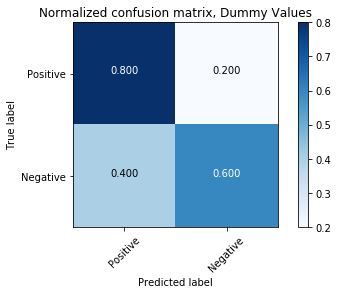

In [15]:
cnf_matrix = np.array([[8,2],[8,12]])
# [TP, FN], [FP, TN]
class_names = ["Positive", "Negative"]

np.set_printoptions(precision=3)
# Plot normalized confusion matrix

plt.Figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Dummy Values')

plt.show()

Now, let's reload our model from disk, and run it on the test set:

In [21]:
running_stats = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    conf_mat = np.zeros(4, dtype=int)
    running_stats = []
    for i, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {inputs: x,
                labels: y[:, None],
                keep_prob: 1}
        v_loss, v_acc, v_prec, v_rec, v_f1, true_pos, false_neg, false_pos, true_neg = \
            sess.run([loss, accuracy, precision, recall, f1, TP, FN, FP, TN], feed_dict=feed)
        running_stats.append([v_loss, v_acc, v_prec, v_rec, v_f1])
        conf_mat += (true_pos, false_neg, false_pos, true_neg)
        
    running_stats = np.array(running_stats)
    test_averages = running_stats.mean(axis=0)
    print("Test loss: {:.3f}".format(test_averages[0]),
                 "accuracy: {:.3f}".format(test_averages[1]),
                 "precision: {:.3f}".format(test_averages[2]),
                 "recall: {:.3f}".format(test_averages[3]),
                 "f1: {:.3f}".format(test_averages[4]))

INFO:tensorflow:Restoring parameters from checkpoints/sentiment.ckpt
Test loss: 0.119 accuracy: 0.851 precision: 0.884 recall: 0.810 f1: 0.845


[[ 0.808  0.192]
 [ 0.107  0.893]]


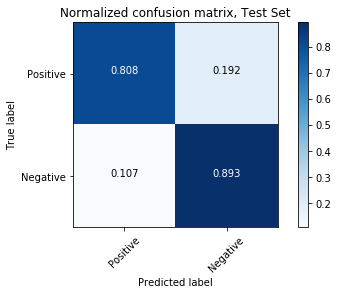

In [22]:
# Reshape into 2 x 2 matrix
conf_mat = conf_mat.reshape((2,2))

class_names = ["Positive", "Negative"]

# Plot normalized confusion matrix

plt.Figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix, Test Set')

plt.show()

# Conclusion
As can be seen above, when the model is given a negative review, it classifies that review correctly almost 90% of the time!

When the model is given a positive review, its accurate only about 80% of the time, but still that is an incredible first pass.

As can also be seen above, we've taken care to gather information about true positives, true negatives, false positives, and false negatives.

This allows us to relate the following metrics:

![Precision](https://wikimedia.org/api/rest_v1/media/math/render/svg/26106935459abe7c266f7b1ebfa2a824b334c807)

![Recall](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c233366865312bc99c832d1475e152c5074891b)

![Accuracy](https://wikimedia.org/api/rest_v1/media/math/render/svg/e2e427ec6dcf2d7882c3bbdc659a8204cba59dcc)

![F1 Score](https://wikimedia.org/api/rest_v1/media/math/render/svg/dd577aee2dd35c5b0e349327528a5ac606c7bbbf)

As can be seen from running the test set above, precision was **0.884**.  
Also, recall was **0.810**, accuracy was **0.851**, and the F1 score was **0.845**.